# 應用多變量分析 HW5
## 105024519 許閔翔 MDS VS PCA

In [51]:
import IPython.core.display as di

di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.plotly as py
from matplotlib.mlab import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance


In [2]:
def plot_data(data, labels, filename):
    plt.figure(figsize=(8,6))
    plt.scatter(data[:,0], data[:,1], c=["w" for _ in labels])
    for d, l in zip(data,labels):
        plt.text(d[0], d[1], str(l), fontdict={"size":12, "color":cm.Paired(1)})
    plt.title(filename)
    plt.show()

# Import data

In [3]:
df_original = pd.read_csv('anova.csv')
column_name = ["PREDDEG", "HIGHDEG", "CONTROL", 
               "ST_FIPS", "REGION", "LATITUDE", "LONGITUDE",
               "UGDS", 'UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN', 'UGDS_AIAN', 'UGDS_NHPI',
               'DEP_STAT_PCT_IND', 'IND_INC_PCT_LO', 'DEP_INC_PCT_LO', 'INC_PCT_M1', 'INC_PCT_M2', 
               'INC_PCT_H1', 'INC_PCT_H2', 
               'PAR_ED_PCT_MS', 'PAR_ED_PCT_HS', 'PAR_ED_PCT_PS',
               'FEMALE', 'MARRIED', 'DEPENDENT', 'VETERAN', 'UGDS_MEN', 'UGDS_WOMEN']

df = df_original[column_name]
del df["PAR_ED_PCT_MS"]
print('\n Size of original data: \n%s' % df.shape[0])
df = df.dropna(axis = 0)
print('\n Size of dropna data: \n%s' % df.shape[0])


 Size of original data: 
7703

 Size of dropna data: 
2637


In [14]:
### categoricl and numerical varibles
### standarize numerical varibles(Z)

X1 = df.iloc[:100, :7]
X2 = df.iloc[:100, 7:]
sc = StandardScaler()
Z = pd.DataFrame(sc.fit_transform(X2))
print("standardize numerical data : Z")

standardize numerical data : Z


# PCA

In [6]:
C = np.dot(Z.T, Z) / df.shape[0]
eigen_vals, eigen_vecs = np.linalg.eigh(C)

eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(reverse=True)

# calculate projection matrix
P = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))

Z_pca = pd.DataFrame(Z.dot(P))
data_cat = df.iloc[:100,:7]
result_pca = pd.DataFrame(np.hstack([ data_cat, Z_pca ]))
result_pca.columns = ["PREDDEG", "HIGHDEG", "CONTROL", 
                  "ST_FIPS", "REGION", "LATITUDE", "LONGITUDE", 
                  "com1", "com2"]

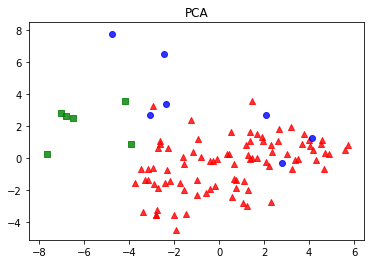

In [9]:
fig, ax = plt.subplots()

# 先畫出原本散佈圖的點。
data_1 = np.array(result_pca[result_pca.CONTROL == 1])
data_2 = np.array(result_pca[result_pca.CONTROL == 2])
data_3 = np.array(result_pca[result_pca.CONTROL == 3])
ax.scatter(data_1[:, [7]], data_1[:, [8]], color='r', marker='^', alpha=.8)
ax.scatter(data_2[:, [7]], data_2[:, [8]], color='b', alpha=.8)
ax.scatter(data_3[:, [7]], data_3[:, [8]], color='g', marker='s', alpha=.8)
ax.autoscale()

plt.title('PCA')
plt.show()

# MDS plot

In [10]:
def cmdscale(D):
    # Number of points                                                                        
    n = len(D)
 
    # Centering matrix                                                                        
    H = np.eye(n) - np.ones((n, n))/n
 
    # YY^T                                                                                    
    B = -H.dot(D**2).dot(H)/2
 
    # Diagonalize                                                                             
    evals, evecs = np.linalg.eigh(B)
 
    # Sort by eigenvalue in descending order                                                  
    idx   = np.argsort(evals)[::-1]
    evals = evals[idx]
    evecs = evecs[:,idx]
 
    # Compute the coordinates using positive-eigenvalued components only                      
    w, = np.where(evals > 0)
    L  = np.diag(np.sqrt(evals[w]))
    V  = evecs[:,w]
    Y  = V.dot(L)
 
    return Y, evals

### 1. Metric MDS plot euclidean_distance

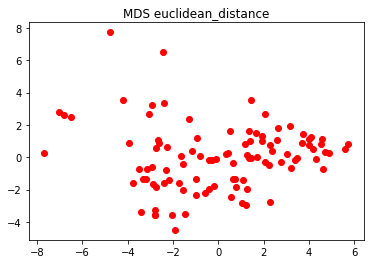

In [21]:
from sklearn.metrics.pairwise import pairwise_distances

### MDS euclidean_distance
metric_e = pairwise_distances(Z, Y=None, metric='euclidean', n_jobs=1)
mds_all = cmdscale(metric_e)

mds_e = np.hstack((mds_all[0][:, 0].reshape(100, 1), mds_all[0][:, 1].reshape(100, 1)))
plt.scatter(mds_all[0][:, 0], mds_all[0][:, 1], c='r', cmap=plt.cm.Spectral)
plt.title("MDS euclidean_distance")
plt.axis('tight')
plt.show()

### 2. Metric MDS plot 1-correlation

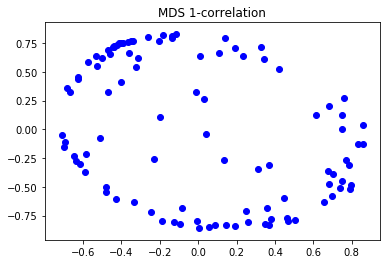

In [18]:
from sklearn import manifold

seed = np.random.RandomState(seed=1)
mds = manifold.MDS(n_components=2, metric=True, n_init=4, max_iter=300,
                   verbose=0, eps=0.001, n_jobs=1, random_state=seed, dissimilarity='precomputed')

metric_c = distance.cdist(Z, Z, 'correlation')
mds_c = mds.fit_transform(metric_c)

plt.scatter(mds_c[:, 0], mds_c[:, 1], c='b', cmap=plt.cm.Spectral)
plt.title("MDS 1-correlation")
plt.axis('tight')
plt.show()

### 3. Non-metric MDS plot euclidean_distance

/Users/Shawn/anaconda/lib/python3.6/site-packages/sklearn/manifold/mds.py:238: UserWarning:

Explicit initial positions passed: performing only one init of the MDS instead of 4



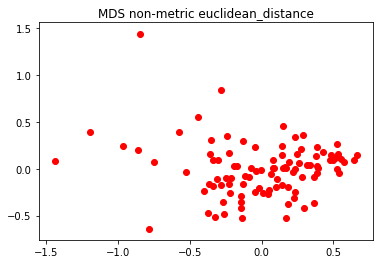

In [20]:
seed = np.random.RandomState(seed=1)
mds_not = manifold.MDS(n_components=2, metric=False, n_init=4, max_iter=100, 
                       verbose=0, eps=0.001, n_jobs=1, random_state=seed, dissimilarity='precomputed')

metric_e = pairwise_distances(Z, Y=None, metric='euclidean', n_jobs=1)
mds_e_not = mds_not.fit_transform(metric_e, init = mds_e)

plt.scatter(mds_e_not[:, 0], mds_e_not[:, 1], c='r', cmap=plt.cm.Spectral)
plt.title("MDS non-metric euclidean_distance")
plt.axis('tight')
plt.show()

### 4. Non-metric MDS plot 1-correlation

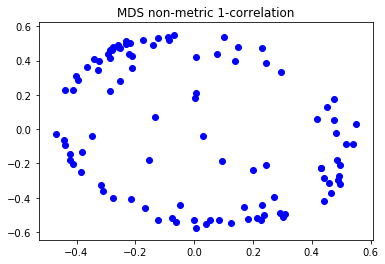

In [63]:
metric_c = distance.cdist(Z, Z, 'correlation')
mds_c_not = mds_not.fit_transform(metric_c, init = mds_c)

plt.scatter(mds_c_not[:, 0], mds_c_not[:, 1], c='b', cmap=plt.cm.Spectral)
plt.title("MDS non-metric 1-correlation")
plt.axis('tight')
plt.show()